In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import richardsplot
import sklearn
%matplotlib inline

/Users/trevormccaffrey/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
def trevorFit(data, fit):
    #Use: Project scattered data (data) onto a line of best fit (fit)
    #Returns: 2-D array of (x,y) locations on the line of your orthogonal projection
    
    #data: 2-D (N by 2) array of your data in some x-y space
    #fit: 2-D (N by 2) array of coordinates along your line of best fit
    
    trevorFit = np.array([]).reshape(0, 2) 
    
    for scat in data: 
        r = np.sqrt((scat[0]-fit[:,0])**2 + (scat[1]-fit[:,1])**2) #dist of data point from each point along fit
        delta = np.array([fit[np.argmin(r), 0], fit[np.argmin(r), 1]]) #we want to take the index of fit where
        trevorFit = np.concatenate((trevorFit, np.atleast_2d(delta)))  #the displacement was minimum (min r)
        
    return trevorFit


def sudo_pca(fit, data):
    #fit: 2-D array containing coordinates of points along best fit line ([cz, cfit(cz)] here)
    #data: 2-D [x,y] array of data (N by 2 shape)
    #NOTE: This really just caters to this situation (assumes monotonically decreasing function)
    
    data = trevorFit(data, fit) #project data onto fit
    
    #
    if fit[0,1] < fit[-1,1]: #Compare EQW at endpoints [Blueshift, EQW] - want fit[0,1] to be top left of plot
        fit  = np.flip(fit, axis=0)
    
    darr = [] #list to fill with distances for each point

    for scat in data:
        d = 0 #start at beginning of the line
        for i in range(fit.shape[0]-1):
            xp, x = fit[i,0], fit[i+1,0]
            yp, y = fit[i,1], fit[i+1,1] 
            dp = d
            d += np.sqrt((x-xp)**2 + (y-yp)**2)
            if yp > scat[1] >= y: #if we pass the projected y-coord, save the distance traveled
                darr.append(d)
                
    return np.array(darr).reshape(len(darr),1)


#9/10/2020: I need a function that's an extension of trevorFit that will tell me
#the index of the point along the best fit line that each target was projected down
#to.  That way, I can take the index from the scaled projection and plot it in 
#"raw" CIV space

def trevorFit_indices(data, fit):
    #Use: Project scattered data (data) onto a line of best fit (fit);
          #also return indices for plotting orth. projs in "Raw" CIV space 
    
    #data: 2-D (N by 2) array of your data in some x-y space
    #fit: 2-D (N by 2) array of coordinates along your line of best fit
    
    
    trevorFit = np.array([]).reshape(0, 2) 
    fit_indices = np.array([])
    
    for scat in data: 
        r = np.sqrt((scat[0]-fit[:,0])**2 + (scat[1]-fit[:,1])**2) #dist of vla point from each point along fit
        delta = np.array([fit[np.argmin(r), 0], fit[np.argmin(r), 1]]) #we want to take the index of fit where
        trevorFit = np.concatenate((trevorFit, np.atleast_2d(delta)))  #the displacement was minimum (min r)
        fit_indices = np.append(fit_indices, np.argmin(r))
    
    return trevorFit, fit_indices

In [3]:
np.argmin([1,2,3])

0

In [4]:
infile = 'SDSSRMMedianCIVParams_wCIVDist.csv' #load in refined CIV params to base fit off of
df = pd.read_csv(infile)
print(df.head())

   RMID_1          RA        DEC  \
0      10  213.764157  52.922335   
1      11  213.892516  52.962006   
2      19  213.873727  52.868186   
3      31  214.170380  53.115956   
4      34  213.225037  53.137408   

                                              PSFMAG  \
0  (22.532715, 20.543663, 20.141333, 19.901579, 1...   
1  (20.520481, 20.502234, 20.364378, 20.174232, 2...   
2  (20.681818, 20.364162, 20.384111, 20.117191, 1...   
3  (19.870947, 19.98295, 19.924612, 19.675512, 19...   
4  (20.235037, 20.16954, 20.047485, 19.84725, 19....   

                                           FIBER2MAG  OBJC_TYPE    ZPIP  \
0  (23.24768, 21.35396, 20.95871, 20.71041, 20.55...          6  3.2299   
1  (21.31451, 21.33308, 21.18767, 20.97824, 20.83...          6  2.0543   
2  (21.47477, 21.17687, 21.1949, 20.91205, 20.78988)          6  1.9166   
3  (20.71221, 20.82329, 20.79188, 20.53111, 20.4844)          6  1.9090   
4   (21.07218, 20.9689, 20.8534, 20.65883, 20.51734)          6  1.8250

In [5]:
X = df[['Median_CIV_Blueshift','Median_CIV_EQW']].values
print(X.shape)
print(X)

(133, 2)
[[3043.60172446   38.74672887]
 [ 120.04027158  114.02632724]
 [ 358.18468132   70.26407662]
 [ 211.03854197  112.87336174]
 [1061.00111006   74.05104105]
 [ 892.55750317   86.79104174]
 [ 455.95941865  174.75948973]
 [ 249.76121022   73.63163225]
 [ -47.4352686   155.61844579]
 [ 534.37282186  133.62634829]
 [ 242.01667657  130.1485973 ]
 [1239.12538401   87.677081  ]
 [ 484.03335313   78.98083387]
 [ 125.84867182   93.57768234]
 [ 241.04860986  105.72359399]
 [ 543.08542221  114.39753791]
 [  30.97813461  116.34682487]
 [ 846.09030127  110.21867766]
 [ 866.4197021    56.426101  ]
 [ -44.53106848  229.42128885]
 [-369.80148178  283.38222144]
 [ 798.65503266   85.9218011 ]
 [ -85.18987014  269.12505753]
 [1189.75398199   84.17604249]
 [  75.5092031   130.98829856]
 [1858.68807601   50.14783143]
 [ 748.31556394   72.32212506]
 [ 333.01494696   94.35379694]
 [ 379.48214886   95.22940038]
 [3777.3962878    35.56164166]
 [ 303.97294577  144.90602435]
 [-102.61507085  138.0744291 ]

In [6]:
x = X[:,0] 
y = X[:,1]

Text(0, 0.5, 'EQW')

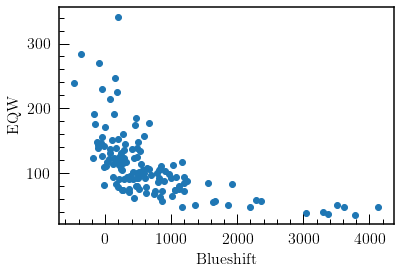

In [7]:
plt.scatter(x, y)
plt.xlabel('Blueshift')
plt.ylabel('EQW')

In [8]:
z = np.arange(min(x),max(x),100)
print(z)

[-470.48041923 -370.48041923 -270.48041923 -170.48041923  -70.48041923
   29.51958077  129.51958077  229.51958077  329.51958077  429.51958077
  529.51958077  629.51958077  729.51958077  829.51958077  929.51958077
 1029.51958077 1129.51958077 1229.51958077 1329.51958077 1429.51958077
 1529.51958077 1629.51958077 1729.51958077 1829.51958077 1929.51958077
 2029.51958077 2129.51958077 2229.51958077 2329.51958077 2429.51958077
 2529.51958077 2629.51958077 2729.51958077 2829.51958077 2929.51958077
 3029.51958077 3129.51958077 3229.51958077 3329.51958077 3429.51958077
 3529.51958077 3629.51958077 3729.51958077 3829.51958077 3929.51958077
 4029.51958077 4129.51958077]


In [9]:
from scipy.interpolate import interp2d    
#fit = interp2d(x, y, z, kind='cubic')
fit = np.poly1d(np.polyfit(x,y,5))

In [10]:
print(fit)
print(fit(z))

            5             4             3             2
-1.505e-15 x + 1.661e-11 x - 6.643e-08 x + 0.0001243 x - 0.139 x + 152.2
[252.85924342 224.44571781 200.28743951 179.84852361 162.6378405
 148.20721027 136.14959708 126.0973036  117.72016532 110.72374503
 104.84752713  99.86311205  95.57241067  91.80583864  88.42051085
  85.29843573  82.34470972  79.48571162  76.66729697  73.85299246
  71.02219032  68.16834269  65.29715603  62.42478547  59.57602927
  56.78252313  54.08093464  51.51115762  49.11450656  46.93191096
  45.00210975  43.35984567  42.03405966  41.04608525  40.40784293
  40.12003457  40.1703378   40.53160039  41.16003462  41.99341172
  42.94925622  43.92304035  44.78637842  45.38522123  45.53805043
  45.03407295  43.63141534]


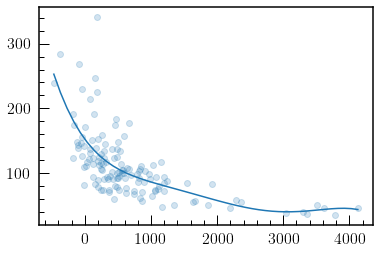

In [11]:
plt.scatter(x, y, alpha=0.2)
plt.plot(z, fit(z))

3rd degree polynomial fit of RM objects in CIV EQW vs. Blueshift space.  The fit works well for high blueshift, low EQW objects, but not so much for the opposite end of the distribution.  I try to fit the other end better below

In [12]:
x2 = X[:,1] #x is EQW here
y2 = X[:,0] #and y is blueshift
X2 = np.array([x2,y2]).T

In [13]:
fit2 = np.poly1d(np.polyfit(x2,y2,2))
print(fit2)

         2
0.08477 x - 35.41 x + 3357


In [14]:
z2 = np.arange(min(x2),max(x2),5)

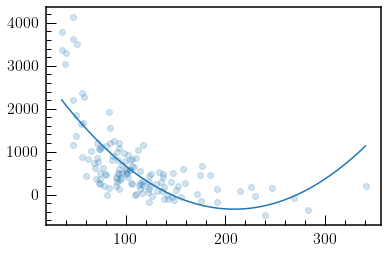

In [15]:
plt.scatter(x2, y2, alpha=0.2)
plt.plot(z2, fit2(z2))

Now this fit works in the opposite manner as the one described above.  An even better fit would be a sort of combination between the two (see below)

In [16]:
infile2 = '../SpringFinalFigs_moreParams.csv' #Trevor's final values -- radio/optical properties of VLA objects
df2 = pd.read_csv(infile2)

#New blueshift/eqw values based on ICA reconstructions from Angelica
infile3 = 'AllVLACIVParams.csv'
df3 = pd.read_csv(infile3)
ica_blueshift = df2[['ICA_CIV_BLUESHIFT']].values
ica_eqw = df2[['ICA_CIV_EQW']].values

In [17]:
vla_data = df2[['VOFF_CIV_PEAK_2', 'EW_CIV_2']].values

#### Details of our best-fit line

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


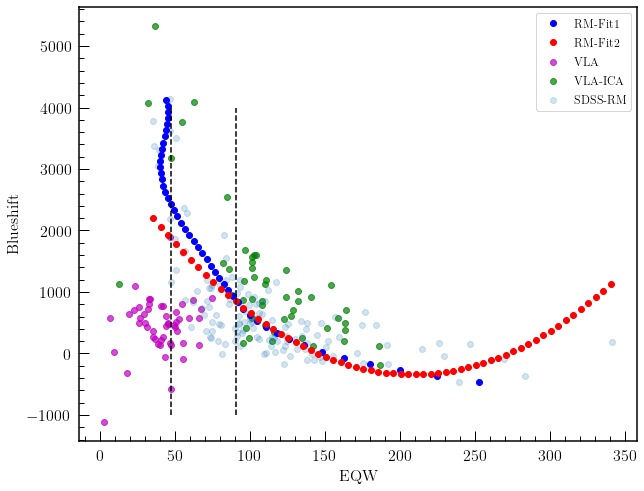

In [18]:
plt.figure(figsize=(10,8))
plt.scatter(vla_data[:,1], vla_data[:,0], label="VLA", color='m', alpha=0.7)
plt.scatter(ica_eqw, ica_blueshift, label="VLA-ICA", color='g', alpha=0.7)
plt.scatter(x2, y2, alpha=0.2, label="SDSS-RM")
plt.plot(fit(z), z, 'bo', label="RM-Fit1")
plt.plot(z2, fit2(z2), 'ro', label="RM-Fit2")
plt.xlabel("EQW")
plt.ylabel("Blueshift")
plt.legend(loc="best")

#Draw out which fit points to keep for each, do another fit for those points
plt.plot([fit(z)[29],fit(z)[29]], [-1000,4000], '--k')
plt.plot([z2[11],z2[11]], [-1000,4000], '--k')

Black lines indicate the breakpoints in the data we want to use.  We want to use all of the blue datapoints to the left of the leftmost black line, and all of the red to the right of the rightmost black line to manufacture our new line of best fit.

(Ignore the green datapoints at (0,0) -- they won't affect the fit and aren't real values)

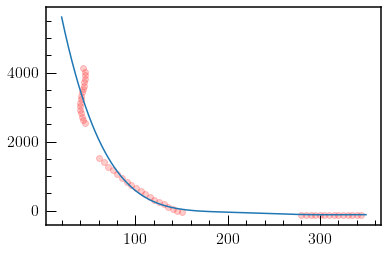

In [19]:
#mess around with how many points to take from each fit -- check by eye in cell below
cx = np.concatenate((fit(z)[30:(len(fit(z)))], z2[5:len(z2)-38]))
cy = np.concatenate((z[30:(len(fit(z)))], fit2(z2)[5:len(z2)-38]))
cx = np.concatenate((cx, np.arange(280, 350, 5)))
cy = np.concatenate((cy, np.zeros(len(np.arange(280, 350, 5)))-115))
plt.scatter(cx, cy, color='r', alpha=0.2)
cfit = np.poly1d(np.polyfit(cx, cy, 5))
cz = np.arange(20, 350, 0.001)
plt.plot(cz, cfit(cz))



This illustrates how we get the line we want -- can choose which 'left' data points to use to determine the end behavior of our fit

Note that the axes are flipped here from above and below

In [20]:
#Parameters to test
uniform = df2[['UNI_FLAG']].values.astype("int").flatten()
Miz2 = df2[['MI_Z2']].values.flatten()
z = df2[["redshift_1"]].values.flatten()
det = df2[['detection']].values.astype("int").flatten()
peak_flux = df2[['peak_flux']].values.flatten()
int_flux = df2[['int_flux']].values.flatten()
ew_civ = df2[['ICA_CIV_EQW']].values.flatten()
voff_civ = df2[['ICA_CIV_BLUESHIFT']].values.flatten()
log_bh = df2[['LOGBH']].values.flatten()
logedd_ratio = df2[['LOGEDD_RATIO']].values.flatten()
logL_bol = df2[['LOGLBOL']].values.flatten()
logL_civ = df2[['LOGL_CIV']].values.flatten()
fwhm_civ = df2[['FWHM_CIV']].values.flatten()
F = df2[['FIRST']].values.astype("int").flatten()
CIVdist = df2[["RM_DIST_SCALE"]].values.flatten() #added 8/4/2020

Funi = (det>0)&(uniform>0)&(F>0)
Fnuni = (det>0)&(uniform==0)&(F>0)
duni = (det>0)&(uniform>0)&(F==0) #eqw mask handles bad indexing below since we're
nduni = (det==0)&(uniform>0)#missing 2 of our targets in the new CIV analysis
dnuni = (det>0)&(uniform==0)&(F==0)
ndnuni = (det==0)&(uniform==0)

ica = (ica_eqw!=0)
#duni = duni[ica].reshape(ica.sum(),1)
#dnuni = dnuni[ica].reshape(ica.sum(),1)
#nduni = nduni[ica].reshape(ica.sum(),1)
#ndnuni = ndnuni[ica].reshape(ica.sum(),1)

Inverse equation:
            5             4            3         2
-8.925e-09 x + 1.149e-05 x - 0.005808 x + 1.443 x - 177.2 x + 8625


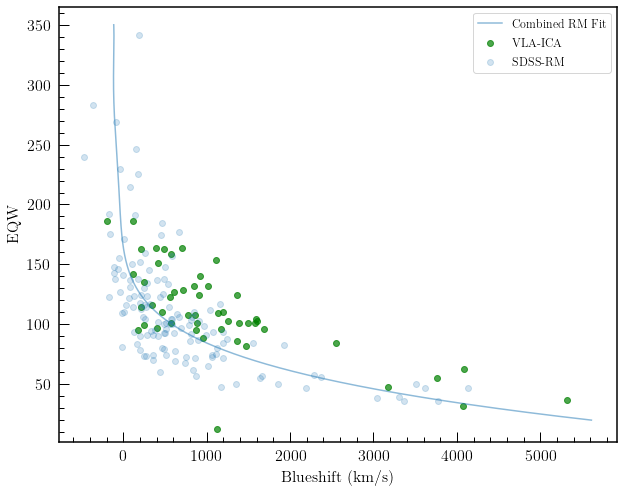

In [21]:
plt.figure(figsize=(10,8))
#plt.scatter(vla_data[:,0], vla_data[:,1], label="VLA", color='m', alpha=0.7)
plt.scatter(ica_blueshift, ica_eqw, label="VLA-ICA", color='g', alpha=0.7)


plt.scatter(x, y, alpha=0.2, label="SDSS-RM")
plt.plot(cfit(cz), cz, label="Combined RM Fit", alpha=0.5)
plt.xlabel("Blueshift (km/s)")
plt.ylabel("EQW")
plt.legend(loc="best")
plt.ylim(2, 365)
print("Inverse equation:")
print(cfit)

#plt.savefig('CIV_RMandVLA.pdf')

In [22]:
duni.shape

(50,)

RM Size:            133
VLA Size:           50
All Data:          (183, 2)
All Data with fit: (330183, 2)


(-1.0, 0.3)

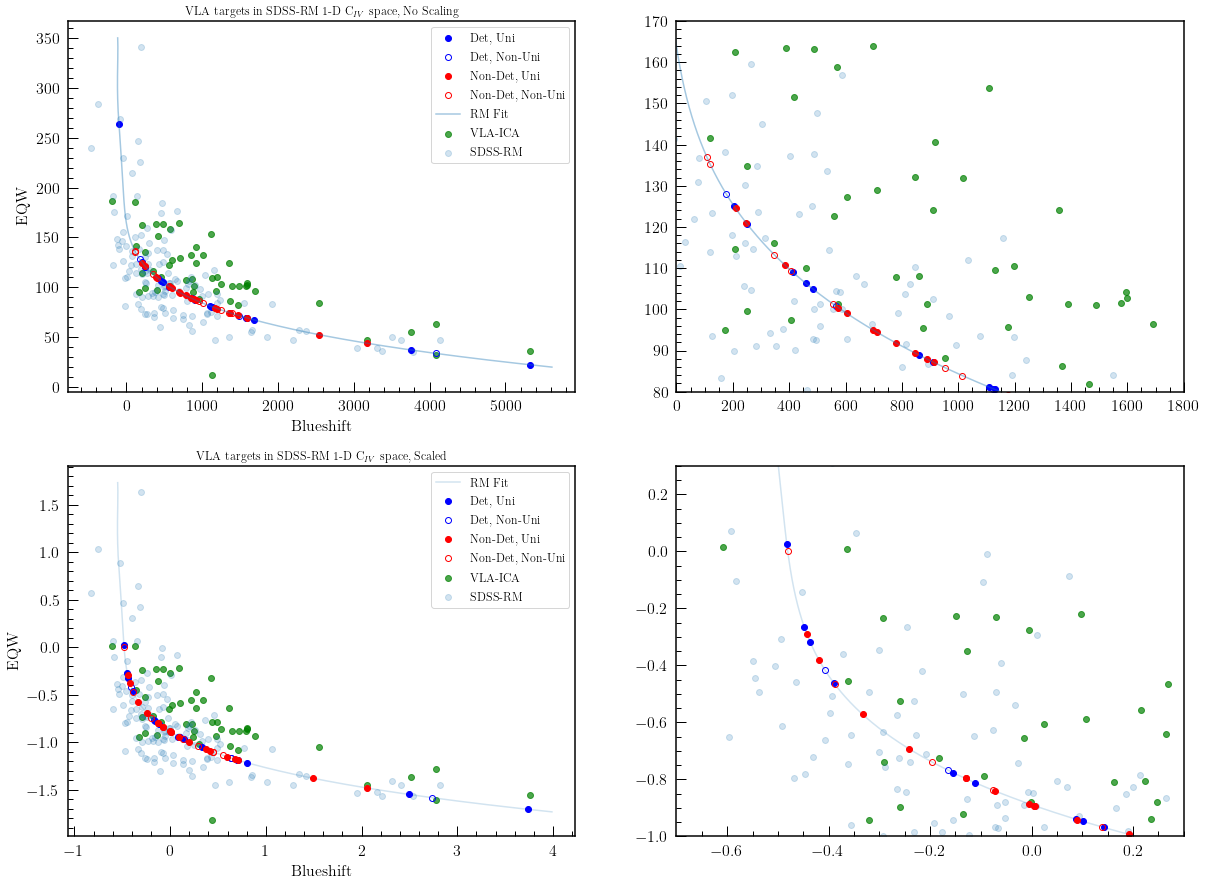

In [23]:
polyfit = np.array([cfit(cz), cz]).T
vla_x = ica_blueshift
vla_y = ica_eqw
vla_ica_data = np.concatenate((vla_x, vla_y), axis=1)

tFit = trevorFit(vla_ica_data, polyfit)
tFitx = tFit[:,0].reshape(len(tFit), 1)
tFity = tFit[:,1].reshape(len(tFit), 1)

fig, axs = plt.subplots(2, 2, figsize=(20,15))

axs[0,0].scatter(vla_x, vla_y, alpha=0.7, color="g", label="VLA-ICA")
axs[0,0].scatter(x, y, alpha=0.2, label="SDSS-RM")
###
axs[0,0].plot(tFitx[duni], tFity[duni], 'bo', label="Det, Uni")
axs[0,0].plot(tFitx[dnuni], tFity[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[0,0].plot(tFitx[nduni], tFity[nduni], 'ro', label="Non-Det, Uni")
axs[0,0].plot(tFitx[ndnuni], tFity[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[0,0].plot(cfit(cz), cz, alpha=0.4, label="RM Fit")
axs[0,0].set_xlabel('Blueshift')
axs[0,0].set_ylabel('EQW')
axs[0,0].set_title("VLA targets in SDSS-RM 1-D C$_{IV}$ space, No Scaling")
axs[0,0].legend(loc='best')

axs[0,1].scatter(vla_x, vla_y, alpha=0.7, color="g")
axs[0,1].scatter(x, y, alpha=0.2, label="SDSS-RM")
###
axs[0,1].plot(tFitx[duni], tFity[duni], 'bo', label="Det, Uni")
axs[0,1].plot(tFitx[dnuni], tFity[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[0,1].plot(tFitx[nduni], tFity[nduni], 'ro', label="Non-Det, Uni")
axs[0,1].plot(tFitx[ndnuni], tFity[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[0,1].plot(cfit(cz), cz, alpha=0.4)
axs[0,1].set_ylim(80,170)
axs[0,1].set_xlim(0,1800)

#Now contrast with scaled data
from sklearn.preprocessing import scale

#Want to do same scaling for both VLA and RM objects
print("RM Size:           ", len(x))
print("VLA Size:          ", len(vla_x))
all_data = np.concatenate((X, vla_ica_data), axis=0)
print("All Data:         ", all_data.shape)
zfit_data = np.concatenate((all_data, np.concatenate((np.atleast_2d(cfit(cz)).T, np.atleast_2d(cz).T), axis=1)), axis=0)
print("All Data with fit:", zfit_data.shape)

xsc = scale(zfit_data[:,0])
ysc = scale(zfit_data[:,1])

vla_xsc = xsc[133:183]
vla_ysc = ysc[133:183]
rm_xsc = xsc[:133]
rm_ysc = ysc[:133]
fit_xsc = xsc[183:]
fit_ysc = ysc[183:]

#Now handle morphed together best fit line
tFitsc = trevorFit(np.array([vla_xsc, vla_ysc]).T, np.array([fit_xsc, fit_ysc]).T)
tFitxsc = tFitsc[:,0].reshape(len(tFitsc), 1) 
tFitysc = tFitsc[:,1].reshape(len(tFitsc), 1)
    
axs[1,0].scatter(vla_xsc, vla_ysc, alpha=0.7, color="g", label="VLA-ICA")
axs[1,0].scatter(rm_xsc, rm_ysc, alpha=0.2, label="SDSS-RM")
axs[1,0].plot(fit_xsc, fit_ysc, alpha=0.2, label="RM Fit")
###
axs[1,0].plot(tFitxsc[duni], tFitysc[duni], 'bo', label="Det, Uni")
axs[1,0].plot(tFitxsc[dnuni], tFitysc[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[1,0].plot(tFitxsc[nduni], tFitysc[nduni], 'ro', label="Non-Det, Uni")
axs[1,0].plot(tFitxsc[ndnuni], tFitysc[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[1,0].set_xlabel('Blueshift')
axs[1,0].set_ylabel('EQW')
axs[1,0].set_title("VLA targets in SDSS-RM 1-D C$_{IV}$ space, Scaled")
axs[1,0].legend(loc="best")

axs[1,1].scatter(vla_xsc, vla_ysc, alpha=0.7, color="g")
axs[1,1].scatter(rm_xsc, rm_ysc, alpha=0.2, label="SDSS-RM")
axs[1,1].plot(fit_xsc, fit_ysc, alpha=0.2, label="RM Fit")
###
axs[1,1].plot(tFitxsc[duni], tFitysc[duni], 'bo', label="Det, Uni")
axs[1,1].plot(tFitxsc[dnuni], tFitysc[dnuni], 'bo', markerfacecolor="None", label="Det, Non-Uni")
axs[1,1].plot(tFitxsc[nduni], tFitysc[nduni], 'ro', label="Non-Det, Uni")
axs[1,1].plot(tFitxsc[ndnuni], tFitysc[ndnuni], 'ro', markerfacecolor="None", label="Non-Det, Non-Uni")
###
axs[1,1].set_xlim(-0.7,0.3)
axs[1,1].set_ylim(-1.0,0.3)

In [24]:
tFit.shape, tFitsc.shape

((50, 2), (50, 2))

---
Format a single plot for paper

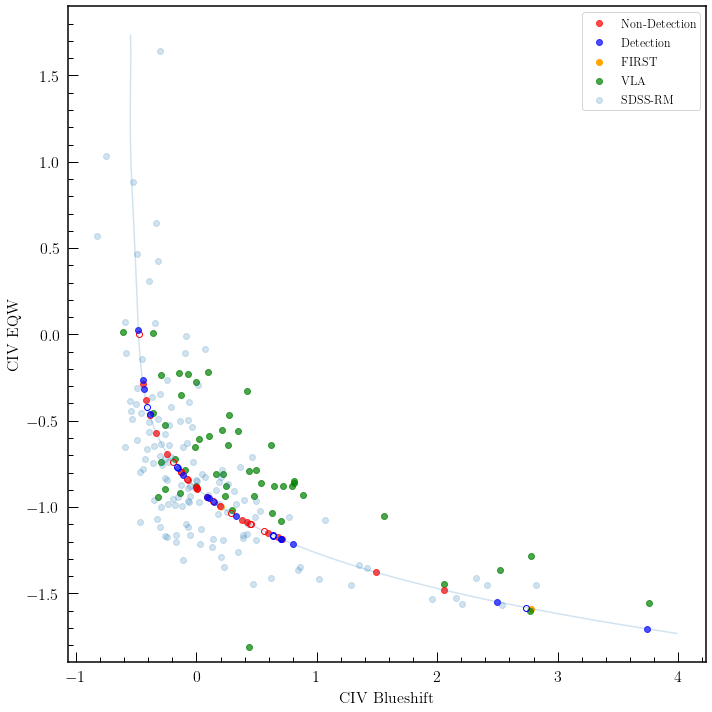

In [25]:
fig = plt.figure(figsize=(10,10))

plt.plot(tFitxsc[nduni], tFitysc[nduni], 'ro', alpha=0.7, label="Non-Detection")
plt.plot(tFitxsc[ndnuni], tFitysc[ndnuni], 'ro', markerfacecolor="None")
plt.plot(tFitxsc[duni], tFitysc[duni], 'bo', alpha=0.7, label="Detection")
plt.plot(tFitxsc[dnuni], tFitysc[dnuni], 'bo', markerfacecolor="None")
plt.scatter(tFitxsc[Funi], tFitysc[Funi], color='orange', marker='o', label="FIRST")
plt.scatter(tFitxsc[Fnuni], tFitysc[Fnuni], edgecolor='orange', marker='o', facecolor="None")
###
plt.scatter(vla_xsc, vla_ysc, alpha=0.7, color="g", label="VLA")
plt.scatter(rm_xsc, rm_ysc, alpha=0.2, label="SDSS-RM")
###
plt.plot(fit_xsc, fit_ysc, alpha=0.2)
plt.xlabel('CIV Blueshift')
plt.ylabel('CIV EQW')
plt.ylim(-1.9,1.9)
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig("../PaperPlots/RadioTargets_1DCIVSpace.pdf")

In [26]:
vla_xsc = vla_xsc.reshape(len(vla_xsc),1)
vla_ysc = vla_ysc.reshape(len(vla_ysc),1)

---

8/4/20: We want a version of the CIV plot which bases the point sizes on the "excess SFR" from Harris.

1. Compute predicted SFR from 1.4GHz luminosity based on 3GHz flux measurements using one of the following

    * Yun+2001: $$ \dot{M} [M_{\odot}  yr^{-1}] \sim 5.9*10^{-22}L_{1.4GHz} $$
    
    * Condon, Cotton, Broderick: $$ \dot{M} [M_{\odot}  yr^{-1}] \sim 1.2*10^{-21}L_{1.4GHz} $$


2. We're interested in the metric

$$ \dot{M}_{measured}  \dot{M}_{predicted} $$

Where the value of the difference is extra radio that our SFR predictions did not account for.  Depending on how this difference trends throughout our CIV space, that may indicate excess radio from winds.

In [29]:
vla_ica_data.shape, vla_ica_data

((50, 2),
 array([[1488.88659422,  101.16025696],
        [ 172.31587372,   95.07953362],
        [ 406.58801663,   97.28951435],
        [ 557.60642281,  122.74090085],
        [1250.74218448,  102.88157079],
        [2546.01543745,   84.6835921 ],
        [1465.65299327,   81.94464428],
        [ 606.00975812,  127.26887383],
        [ 209.10240856,  114.69145396],
        [ 416.2686837 ,  151.51572009],
        [1576.01259778,  101.43455954],
        [ 915.79110412,  140.57835598],
        [1198.46658234,  110.42108715],
        [4079.43310015,   32.10799193],
        [1130.70191291,  109.61335499],
        [1016.47004157,  131.94216478],
        [ 116.16800476,  185.91175214],
        [ 249.76121022,   99.50131623],
        [ 389.16281592,  163.50694551],
        [1175.23298139,   95.78924437],
        [ 911.9188373 ,  124.09789459],
        [ 952.57763896,   88.16753564],
        [ 346.56788085,  116.01023052],
        [4089.11376721,   62.90507871],
        [1122.95737925,   12.2

In [30]:
polyfit.shape, polyfit

((330000, 2),
 array([[5613.73826784,   20.        ],
        [5613.61216272,   20.001     ],
        [5613.48605984,   20.002     ],
        ...,
        [-115.58195977,  349.997     ],
        [-115.58252687,  349.998     ],
        [-115.58309405,  349.999     ]]))

In [27]:
tFit

array([[1488.23951241,   71.562     ],
       [ 176.01555211,  128.09      ],
       [ 407.32542939,  109.349     ],
       [ 556.56168566,  101.255     ],
       [1250.08588298,   77.312     ],
       [2545.50711871,   52.444     ],
       [1465.43598041,   72.08      ],
       [ 604.71706894,   98.999     ],
       [ 210.07857519,  124.502     ],
       [ 413.69821382,  108.961     ],
       [1575.33666112,   69.639     ],
       [ 914.02718692,   87.099     ],
       [1197.60282492,   78.693     ],
       [4079.4711195 ,   33.748     ],
       [1129.90076673,   80.546     ],
       [1015.00313095,   83.899     ],
       [ 108.63398079,  136.88      ],
       [ 251.61035185,  120.643     ],
       [ 385.80143075,  110.694     ],
       [1174.79163914,   79.308     ],
       [ 910.70063292,   87.209     ],
       [ 952.49525223,   85.849     ],
       [ 346.37742465,  113.31      ],
       [4088.78655668,   33.653     ],
       [1124.87409602,   80.687     ],
       [1389.48913193,   

In [49]:
#Re-create SFRs from Harris+16 in the CIV plot

#Equations

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on data at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

def SFR_L14(L14):
    #Yun+2001 SFR relation based on 1.4GHz luminosity
    return 5.9e-22 * (10**L14)

def SFR_Mi(Mi):
    #Absolute magnitude SFR relation from Harris+2016
    return -29*Mi**2 - 1625*Mi - 22505

def SFR_eqw(E):
    #Equation 8 of Harris+2016 - compute SFR given EQW measurements
    return 4205*E**(-.5) - 328


L14_mes = radluminosity(1.4, 3., int_flux, -0.7, z) #returns log L
L14_mes[Funi|Fnuni] = radluminosity(1.4, 1.4, int_flux[Funi|Fnuni], -0.7, z[Funi|Fnuni])
SFR_mes = 5.9e-22 * 10**(L14_mes)

avgSFR = (SFR_eqw(ew_civ)+SFR_Mi(Miz2))/2 #avg the EQW and Mi SFRs from Harris+16

#Take the difference between the two SFRs
SFRdiff = SFR_mes - avgSFR
#Scale sizes based on SFR
a = 200/15 - 1  
b = np.log(a)/160
c = 200
size = np.array([((c / (1+a*np.e**(-b*x)))) for x in SFRdiff]).reshape(len(SFRdiff), 1)
min(size), max(size)

(array([2.15472833]), array([200.]))

In [50]:
SFRdiff

array([ 2.79416582e+03,  6.85718836e+03,  2.68638026e+02,  4.68554701e+02,
        2.32009487e+02,  2.40220583e+02,  2.01475805e+02,  2.98169861e+02,
        7.00318672e+02,  1.01190251e+03,  1.35015281e+03,  3.74990912e+02,
        4.02467334e+02,  2.01223752e+04,  1.21625580e+03,  3.55034458e+02,
        8.86832538e+03,  3.81402103e+03,  2.82519283e+02,  2.02961999e+02,
        7.33106112e+02,  2.05929156e+02,  3.85496661e+02,  1.07926862e+03,
       -1.27851642e+02,  3.13937570e+02,  1.61553603e+03,  7.13910074e+02,
        4.16354897e+03,  9.26441301e+02,  1.95740221e+02,  5.02971746e+02,
        5.33911010e+02,  2.53049476e+03,  4.07206988e+02,  8.36282389e+02,
        5.88511985e+02,  6.51210674e+02,  7.15531903e+02,  3.44613978e+02,
        5.82721424e+02,  1.81713991e+02,  2.52360603e+02,  2.13063007e+02,
        4.04989122e+02,  3.66536241e+01,  4.68812583e+02,  4.30435965e+02,
        2.07680535e+02,  4.47143296e+05])

In [51]:
df2["CIV_BLUESHIFT_SCALED"] = vla_xsc
df2["CIV_EQW_SCALED"] = vla_ysc

df["CIV_BLUESHIFT_SCALED"] = rm_xsc
df["CIV_EQW_SCALED"] = rm_ysc

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


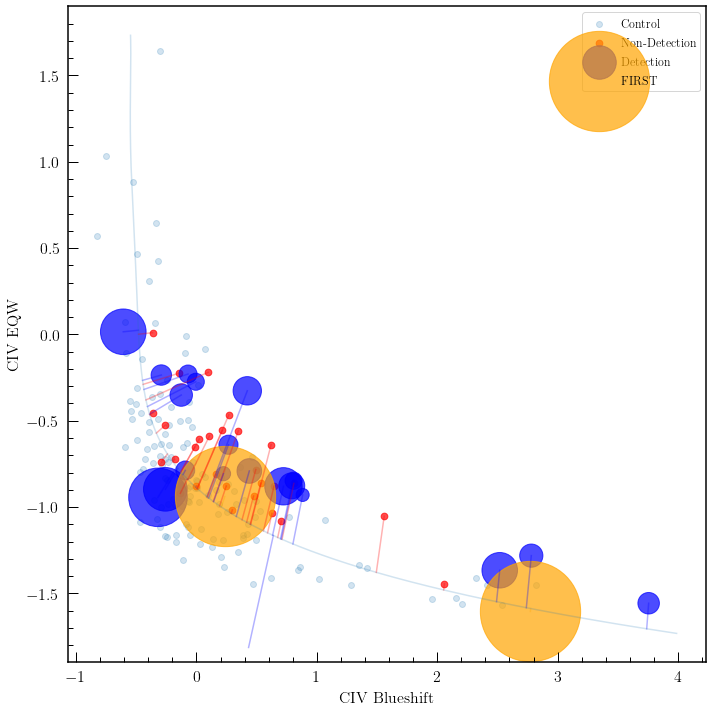

In [52]:
fig = plt.figure(figsize=(10,10))

###
#plt.scatter(vla_xsc, vla_ysc, alpha=0.7, color="g", label="VLA")
plt.scatter(rm_xsc, rm_ysc, alpha=0.2, label="Control")
###

plt.scatter(vla_xsc[nduni], vla_ysc[nduni], s=45, color='red', marker="o", alpha=0.7, label="Non-Detection")
plt.scatter(vla_xsc[ndnuni], vla_ysc[ndnuni], s=45, color='red', marker="o", alpha=0.7, facecolor="red")
plt.scatter(vla_xsc[duni], vla_ysc[duni], s=SFRdiff[duni]/2, color='blue', marker='o', alpha=0.7, label="Detection")
plt.scatter(vla_xsc[dnuni], vla_ysc[dnuni], s=SFRdiff[dnuni]/2, edgecolor='blue', marker='o', alpha=0.7, facecolor="blue")
plt.scatter(vla_xsc[Funi], vla_ysc[Funi], s=SFRdiff[Funi]/2, color='orange', marker='o', alpha=0.7, label="FIRST")
plt.scatter(vla_xsc[Fnuni], vla_ysc[Fnuni], s=SFRdiff[Funi]/2, edgecolor='orange', marker='o', alpha=0.7, facecolor="orange")
#^set the size of brighter FIRST to second FIRST 

colors=["red","blue","orange"]
source=det+F

for i in range(len(vla_xsc)):
    plt.plot([vla_xsc[i],tFitxsc[i]], [vla_ysc[i],tFitysc[i]], color=colors[int(source[i])], alpha=0.3)

plt.plot(fit_xsc, fit_ysc, alpha=0.2)
plt.xlabel('CIV Blueshift')
plt.ylabel('CIV EQW')
plt.ylim(-1.9,1.9)
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig("../PaperPlots/RadioTargets_1DCIVSpace_scaledbySFRdifference_v3.pdf")

Text(0.5, 0, 'CIV Distance (scaled)')

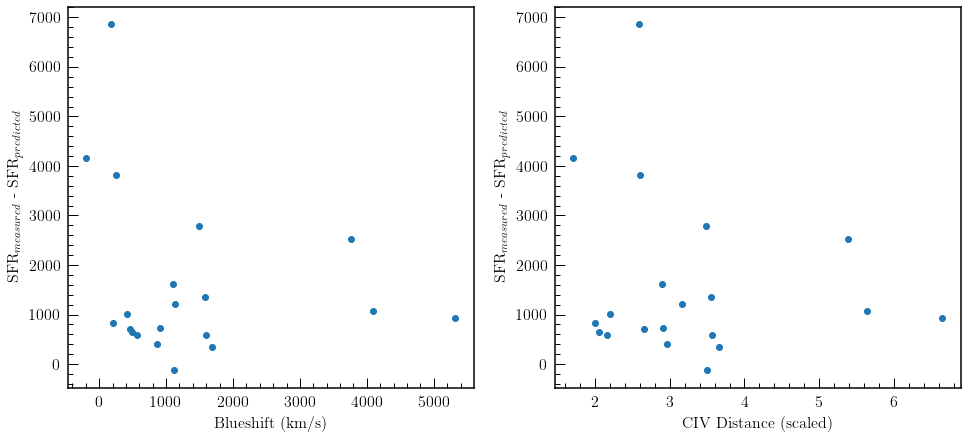

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(16,7))

axs[0].scatter(ica_blueshift[duni|dnuni], SFRdiff[duni|dnuni])
axs[0].set_ylabel("SFR$_{measured}$ - SFR$_{predicted}$")
axs[0].set_xlabel("Blueshift (km/s)")


axs[1].scatter(CIVdist[duni|dnuni], SFRdiff[duni|dnuni])
axs[1].set_ylabel("SFR$_{measured}$ - SFR$_{predicted}$")
axs[1].set_xlabel("CIV Distance (scaled)")

In [54]:
SFRdiff

array([ 2.79416582e+03,  6.85718836e+03,  2.68638026e+02,  4.68554701e+02,
        2.32009487e+02,  2.40220583e+02,  2.01475805e+02,  2.98169861e+02,
        7.00318672e+02,  1.01190251e+03,  1.35015281e+03,  3.74990912e+02,
        4.02467334e+02,  2.01223752e+04,  1.21625580e+03,  3.55034458e+02,
        8.86832538e+03,  3.81402103e+03,  2.82519283e+02,  2.02961999e+02,
        7.33106112e+02,  2.05929156e+02,  3.85496661e+02,  1.07926862e+03,
       -1.27851642e+02,  3.13937570e+02,  1.61553603e+03,  7.13910074e+02,
        4.16354897e+03,  9.26441301e+02,  1.95740221e+02,  5.02971746e+02,
        5.33911010e+02,  2.53049476e+03,  4.07206988e+02,  8.36282389e+02,
        5.88511985e+02,  6.51210674e+02,  7.15531903e+02,  3.44613978e+02,
        5.82721424e+02,  1.81713991e+02,  2.52360603e+02,  2.13063007e+02,
        4.04989122e+02,  3.66536241e+01,  4.68812583e+02,  4.30435965e+02,
        2.07680535e+02,  4.47143296e+05])

In [55]:
fit_xsc

array([ 3.98867564,  3.98857579,  3.98847595, ..., -0.5476034 ,
       -0.54760385, -0.5476043 ])

Now want to actually save the distance along the RM Fit for each point

In [56]:
np.save('RM_CIV_bestFitLine_noScale.npy', np.flip(polyfit, axis=0))

scale_poly = np.concatenate((np.atleast_2d(fit_xsc).T, np.atleast_2d(fit_ysc).T), axis=1)
np.save('RM_CIV_bestFitLine_scale.npy', np.flip(scale_poly, axis=0))

In [57]:
np.save('VLA_CIV_fitXYCoords_noScale.npy', tFit)
np.save('VLA_CIV_fitXYCoords_scale.npy', tFitsc)

np.save('RM_CIVParams_scale.npy', np.array([rm_xsc, rm_ysc]).T)
np.save('VLA_CIVParams_scale.npy', np.array([vla_xsc, vla_ysc]).T)

In [58]:
np.array([vla_xsc, vla_ysc]).T, np.array([fit_xsc, fit_ysc]).T

(array([[[ 7.22759711e-01, -8.79689195e-01],
         [-3.19655781e-01, -9.43522843e-01],
         [-1.34167142e-01, -9.20323115e-01],
         [-1.45959533e-02, -6.53141934e-01],
         [ 5.34205144e-01, -8.61619348e-01],
         [ 1.55975803e+00, -1.05265638e+00],
         [ 7.04364143e-01, -1.08140905e+00],
         [ 2.37281457e-02, -6.05608603e-01],
         [-2.90529466e-01, -7.37642663e-01],
         [-1.26502322e-01, -3.51072332e-01],
         [ 7.91743089e-01, -8.76809647e-01],
         [ 2.69002379e-01, -4.65889569e-01],
         [ 4.92815117e-01, -7.82471720e-01],
         [ 2.77386549e+00, -1.60457959e+00],
         [ 4.39161379e-01, -7.90951055e-01],
         [ 3.48716505e-01, -5.56549767e-01],
         [-3.64111736e-01,  1.00071104e-02],
         [-2.58337223e-01, -8.97104268e-01],
         [-1.47963818e-01, -2.25191969e-01],
         [ 4.74419550e-01, -9.36072508e-01],
         [ 2.65936451e-01, -6.38896612e-01],
         [ 2.98128694e-01, -1.01608297e+00],
         [

In [73]:
np.array([vla_xsc, vla_ysc]).T.reshape(len(vla_xsc),2).shape

(50, 2)

In [74]:
#Save the index of the curve each scaled point was projected onto
tFitsc, indices = trevorFit_indices(np.array([vla_xsc, vla_ysc]).T.reshape(len(vla_xsc),2), np.flip(np.array([fit_xsc, fit_ysc]).T, axis=0))
df2["CIVBestfit_Index"] = indices
df2.to_csv("../SpringFinalFigs_moreParams.csv", index=False)

275801 (0.6326090017954837, -1.1627310505042587) (330000,) (330000, 2)
238121 (-0.1650629244001093, -0.767177476666784) (330000,) (330000, 2)
244881 (-0.07529404336445839, -0.8381419713361399) (330000,) (330000, 2)
240918 (-0.13010434609835805, -0.7965395612215455) (330000,) (330000, 2)
269740 (0.4466709004777981, -1.0991044525470153) (330000,) (330000, 2)
296320 (1.4941765694961666, -1.3781334863209027) (330000,) (330000, 2)
277071 (0.6751032380273414, -1.176063137520543) (330000,) (330000, 2)
240921 (-0.13006524434266195, -0.7965710543404817) (330000,) (330000, 2)
231026 (-0.2412970050465385, -0.6926962503828964) (330000,) (330000, 2)
209035 (-0.3895957963247222, -0.46184119087493697) (330000,) (330000, 2)
277755 (0.6985214374085288, -1.1832435686379748) (330000,) (330000, 2)
249988 (0.005302243076670494, -0.891753757471702) (330000,) (330000, 2)
267286 (0.3788677390781686, -1.0733430812572815) (330000,) (330000, 2)
316280 (2.776145692553612, -1.587667704309119) (330000,) (330000, 2)

In [61]:
np.array(0-np.array([fit_xsc, fit_ysc]).T).shape

(330000, 2)

In [62]:
np.array([rm_xsc, rm_ysc]).T

array([[ 1.95372977, -1.53488808],
       [-0.36104581, -0.74462497],
       [-0.17249124, -1.20402822],
       [-0.2889965 , -0.75672846],
       [ 0.38397468, -1.16427378],
       [ 0.25060681, -1.030533  ],
       [-0.09507656, -0.10706607],
       [-0.25833722, -1.16867661],
       [-0.49364719, -0.30800312],
       [-0.03299152, -0.5388697 ],
       [-0.26446908, -0.57537811],
       [ 0.52500736, -1.02123162],
       [-0.07284858, -1.11252227],
       [-0.35644692, -0.95928884],
       [-0.26523556, -0.83178462],
       [-0.02609318, -0.74072811],
       [-0.43156215, -0.72026507],
       [ 0.21381568, -0.78459656],
       [ 0.2299118 , -1.34929523],
       [-0.49134774,  0.46675745],
       [-0.74888569,  1.03322347],
       [ 0.17625806, -1.03965803],
       [-0.52353999,  0.88355595],
       [ 0.48591678, -1.05798449],
       [-0.39630398, -0.56656317],
       [ 1.01555583, -1.41520266],
       [ 0.136401  , -1.18242343],
       [-0.19241977, -0.95114141],
       [-0.15562864,

In [63]:
unscale_distance = sudo_pca(polyfit, vla_ica_data)

rm_data_scale = np.array([rm_xsc, rm_ysc]).T
vla_data_scale = np.array([vla_xsc, vla_ysc]).T
scale_distance = sudo_pca(scale_poly, vla_data_scale) 

ValueError: operands could not be broadcast together with shapes (2,) (330000,) 

In [ ]:
unscale_distance.shape
df2.shape

In [ ]:
#Now save to file -- VLA
df2['ICA_CIV_BLUESHIFT'] = ica_blueshift
df2['ICA_CIV_EQW'] = ica_eqw
df2['RM_DIST_UNSCALE'] = unscale_distance
df2['RM_DIST_SCALE'] = scale_distance

df2.to_csv('SpringFinalFigs_moreParams.csv', index=False)


#Now save to file -- RM
#df['RM_DIST_UNSCALE'] = unscale_distance
#df['RM_DIST_SCALE'] = scale_distance

df.to_csv('SDSSRMMedianCIVParams_wCIVDist.csv')